# Pipeline HSI - Documentação

   - A Imagem Hiperspectral (Hyperspectral Imaging, HSI) pode ser descrita como uma técnica que combina uma imagem digital com a espectroscopia para se obter tanto as informações espaciais quanto espectrais de uma determinada amostra.
   
   - HSI representa um conjunto de dados tridimensionais chamado hipercubo, com duas dimensões espaciais e uma dimensão espectral. A dimensão espectral da HSI é formada a partir da sobreposição de k imagens digitais, onde cada imagem corresponde distribuição espacial da intensidade de um sinal em um determinado comprimento de onda λ.
   
   - Quando combinadas as informações espaciais com as espectrais de uma amostra, se obtém uma estrutura tridimensional. Que pode ser representada por I(x, y, λ). denominada como cubo hiperspectral. Cada pixel vai conter um espectro contendo uma informação espectral da amostra analisada.
   
   - Para um determinado comprimento de onda λ, uma imagem pode ser vista utilizando uma escala de cinza ou uma outra escala de cor para representar sua intensidade
   
   
   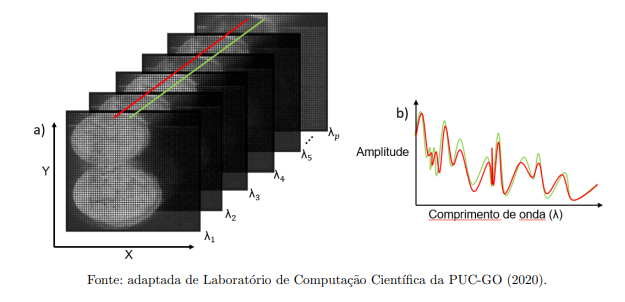
   
   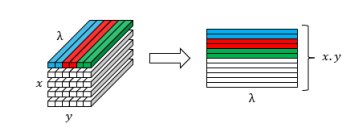
   
   
   
   - A aquisição de HSI é realizada por um equipamento denominado câmera hiperespectral (Hyperspectral Camera, HSC). Essa é adquirida capturando uma linha de cada vez, em que a amostra é disposta em uma bandeja que se movimenta durante a digitalização
   
   - A aquisição da HSI retorna três arquivos para calibração, sendo eles a referencia do Dark, a referencia do White, e a referencia da própria amostra.  
   
   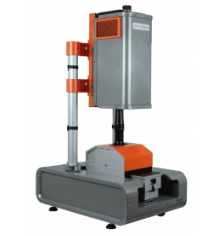
   
   

 
   

### Bibliotecas

Primeiramente, é necessário instalar algumas bibliotecas. 
   - numpy
   - spectral
   - matplotlib
   - scipy
   - joblib
   - scikit-learn (v=0.24.1)
   - pandas
   - ipython
   - seaborn


In [1]:
import pprint
import numpy as np
import seaborn as sns
from utils import Utils
from pipeline import HsiPipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Obtenção do dicionário de amostras


 - Através da função get_dict() que retorna o dicionário com o nome de cada amostra, passando como Parâmetros de entrada a função load_sample() responsável pelo retorno dos diretórios onde encontram os arquivos gerados pela câmera hisperespectral.  

***Os parâmetros e funções são explicidados e objetivados em seu próprio notebook, Utils.py***

In [2]:
##
#
folder = '/Users/Usuario/documento_pipe/HyperSI/Plastico B'
samples_dict = Utils.get_dict(samples=Utils.load_samples(folder))

pprint.pprint(samples_dict)

{'Bacillusscereus_14579_Plastico_B_180926-092335': [1],
 'Coryniumbacteriumglutaminum_13032_Plastico_B_180926-093210': [2],
 'Enterobacteaerogenes_13048_Plastico_B_Contaminado_180926-102747': [3],
 'Enterococcusfaecalis_29212_Plastico_B_180926-093958': [4],
 'Klebsielapneumonial_700603_Plastico_B_180926-105913': [5],
 'Micrococcusluteus_9341_Plastico_B_180926-093534': [6],
 'Pseudomonasaeoruginosas_9027_Plastico_B_180926-104046': [7],
 'Salmonellaspp_10708_Plastico_B_180926-104803': [8],
 'Serratiamarcences_14765_Plastico_B_180926-105123': [9]}


#### Processamento das imagens


Para esta fase, o pipeline é responsável por realizar o processamento das imagens com objetivo de prepara-las para 
a remoção do background e, posteriormente, retornar a matriz que será preparada e utilizada para o treinamento e 
classificação.

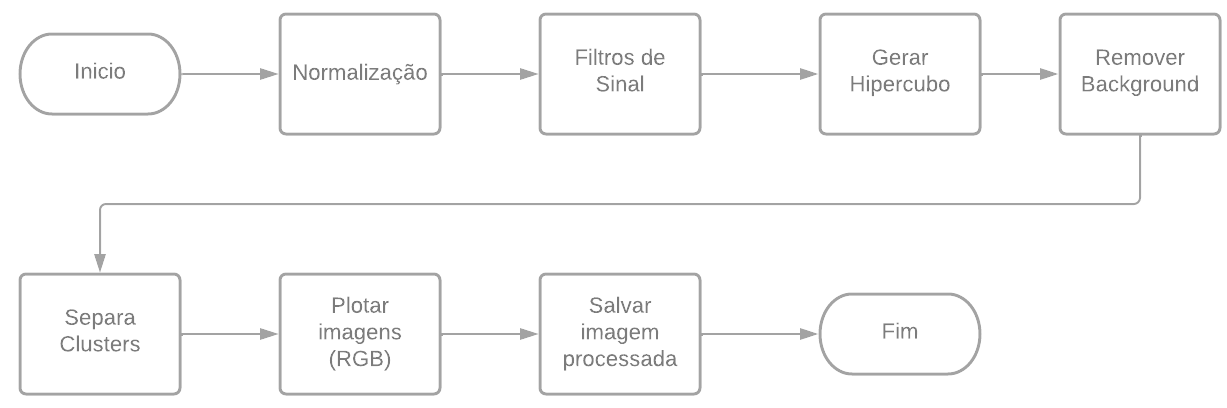


<br>
<div style="text-align: justify"> 
    Inicialmente, os dados são normalizados para correção de sua pseudo-absorbância. Assim, a amostra é 
    normalizada usando o Dark (0% Reflectance) e Referências brancas (100% de refletância).
</div>
     
     
<div style="text-align: justify">Em sequência,as imagens são submetidas a métodos de filtragens de sinal 
    visando normaliza-las e suaviza-las.</div>
<br>
 
 <ul> 
    <li style="text-align: justify">
        O hipercubo obtido é convertido para matriz bidimensional. Então, calcula-se a média normalizada, 
        por cada linha da matriz, para centralizar os dados em zero.
    </li>
    <br>
    <li style="text-align: justify">
        Assim, aplica-se o filtro Savitzky-Golay tem como objetivo a 
        atenuação dos ruídos e conservação do sinal de interesse, pode ser pensado como 
        uma generalização de um filtro de média móvel.
        <br>
        Os coeficientes desse filtro são provenientes da realização de um ajuste 
        linear não-ponderado de mínimos quadrados,
        utilizando um polinômio de determinada ordem no ponto central da janela.
        Baseado na correção de um valor central de uma 
        janela de 2m + 1 pontos pela interpolação
        polinomial de grau p, usando um processo de convolução (Conforme figura abaixo)
    </li>
    <br>
    <li style="text-align: justify">
        Por fim, aplica-se a Standard Normal Variate (SNV), sendo essa o retorno para o 
        processamento das imagens, ao qual realiza uma normalização 
        dos espectros que consiste em subtrair cada espectro  pela sua própria média e 
        dividi-lo pelo seu próprio desvio padrão. Após SNV, cada espectro terá uma média 
        de 0 e um desvio padrão de 1.
    </li>
</ul>
<br>
<div style="text-align: justify"> 
    Os parâmetros de suavização aprimoram a geração do hipercubo, próximo passo ao processamento 
    das imagens, em que a matriz 2D em uma matriz 3D.
</div>
 
<br>
<div style="text-align: justify">
  A remoção do background das imagens, utilizando k-means. 
</div>
<br>
<ul>
  <li style="text-align: justify">
    Para esse processo, a matriz é submetida ao processo de PCA para obtenção de seus scores.
    (Utilizado a biblioteca PCA, sklearn.decomposition - Definição e explicação de PCA em case.ipynb). 
  </li>
  <br>
  <li style="text-align: justify">
    Em seguida, a matriz de scores é aplicada ao algoritmo de K-means para que seja realizada a diferenciação
    entre background e objeto.
    <br>
    K-Means é um algoritmo de clusterização (ou agrupamento) disponível na biblioteca Scikit-Learn.
  
    É um algoritmo de aprendizado não supervisionado (ou seja, que não precisa de inputs de 
    confirmação externos) que avalia e clusteriza os dados de acordo com suas características. 

    O algoritmo k-means procura um número predeterminado de clusters dentro de um conjunto de dados 
    multidimensional não rotulado. Através de umaconcepção simples de como é o agrupamento ideal:
    O "centro do cluster" é a média aritmética de todos os pontos pertencentes ao cluster.
    Cada ponto está mais próximo de seu próprio centro de cluster do que de outros centros de cluster.
    Esses dois pressupostos são a base do modelo k-means.
  </li>
</ul>
<br>
<div style="text-align: justify"> 
    Através da imagem gerada e processada, essa é separada em clusters visando sua identificação 
    quanto a coloração da imagem entre verde e vermelho. 
</div>
<div style="text-align: justify"> 
    Por fim, as imagens são plotadas e salvas. E retorna-se a matriz normalizada para uso na classificação. 
</div>
             
        
<br>
<br>

***Os parâmetros e funções são explicidados e objetivados em seu próprio notebook, pipeline.py***
***As funções individuais para cada passo no processamento de imagens são encontradas em hsiroutni.py***

In [3]:
pipeline = HsiPipeline(data_folder=folder, samples=samples_dict)

In [4]:
pipeline.process_images()

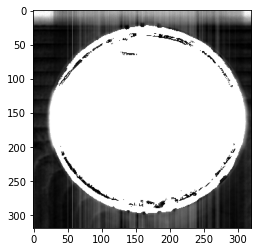

In [5]:
pipeline.visualize_images()

### Preparação dados e Treinamento

<br>

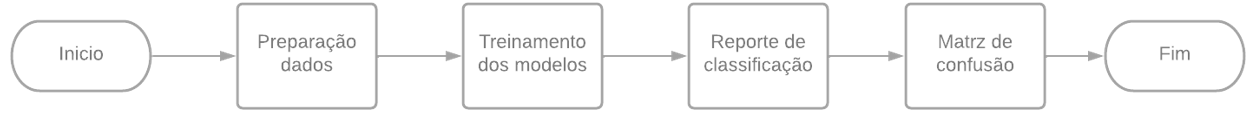

<br>


<div style="align-text: justify">
    Os dados são preparados em treino e teste, ao que são definidos 50% para cada lado. 
    O treinamento é primeiramente selecionado para o tipo de caso a ser especificado, case 0 para 
    classificação por espécie ou case 1 para classificação por coloração gram.
    O range espectral definido é de [1, 241] para que haja remoção de ruídos desnecessários. 
</div>


#### Modelos para treinamento

Os modelos utilizados para o treinamento são  Análise Discriminante Linear e QuadraticDiscriminantAnalysis. 

<br>

<div style="text-align: center"><b>A Análise Discriminante Linear ou LDA:<b/> </div>

<ul>
    <li style="text-align: justify"> Algoritmo de aprendizado de máquina de classificação. Ele funciona calculando estatísticas de resumo para os recursos de entrada por rótulo de classe, como média e desvio padrão. Essas estatísticas representam o modelo aprendido com os dados de treinamento.</li>
   <br>
  <li style="text-align: justify"> Na prática, as operações de álgebra linear são usadas para calcular as quantidades necessárias de forma eficiente por meio da decomposição da matriz. As previsões são feitas estimando a probabilidade de que um novo exemplo pertença a cada rótulo de classe com base nos valores de cada recurso de entrada. A classe que resulta na maior probabilidade é então atribuída ao exemplo. Como tal, LDA pode ser considerado uma simples aplicação do Teorema de Bayes para classificação.</li>
  <br>
  <li style="text-align: justify"> O LDA assume que as variáveis de entrada são numéricas e normalmente distribuídas e que possuem a mesma variância (spread). Se este não for o caso, pode ser desejável transformar os dados para ter uma distribuição gaussiana e padronizar ou normalizar os dados antes da modelagem. </li>
  <br>
  <li style="text-align: justify"> O modelo LDA é naturalmente multiclasse. Isso significa que ele suporta problemas de classificação de duas classes e se estende a mais de duas classessem modificação ou aumento. É um algoritmo de classificação linear, como a regressão logística. Isso significa que as classes são separadas no espaço de recursos por linhas ou hiperplanos. Extensões do método podem ser usadas para permitir outras formas, como Análise Discriminante Quadrática (QDA), que permite formas curvas no limite de decisão. </li>
    
</ul>
    
    
<table>
  <tr>
    <th>Nome</th>
    <th>Valor</th>
    <th style="text-align: justify">Definição</th>
  </tr>
  <tr>
   <td>covariance_estimator</td>
   <td>None</td>
   <td style="text-align: justify">Usado para estimar as matrizes de covariância em vez de<br>
                                   confiar no estimador de covariância empírica (com potencial encolhimento)</td>
 </tr>
 <tr>
  <td>n_compoents</td>
  <td>None</td>
  <td style="text-align: justify">Número de componente para redução de dimensionalidade. 
                                   <br>Se Nenhum, será definido como o minimo entre o número 
                                   <br>de classes -1 e o tamanho do vetor espectral.
                                   <br>Este parâmetro afeta apenas o método de transformação.</td>
 </tr>
 <tr>
  <td>Solver (Otimizador)</td>
  <td>svg</td>
  <td style="text-align: justify">Decomposição de valor singular (padrão). 
                                  <br>Não calcula a matriz de covariância, portanto este solver é 
                                  <br>recomendado para dados com um grande número de características.
  </td>
 </tr>
 <tr>
  <td>store_covariance</td>
  <td>False</td>
  <td  style="text-align: justify">Quando True, calcula a matriz de covariância ponderada dentro 
                                   <br>da classe quando o solver for ‘svd’. A matriz é sempre 
                                   <br>calculada e armazenada para os outros solucionadores.
  </td>
 </tr>
 <tr>
  <td>tol</td>
  <td>0.0001</td>
  <td  style="text-align: justify">Limiar absoluto para que um valor singular de X 
                                  <br>seja considerado significativo, 
                                  <br>utilizado para estimar o rank de X. 
                                  <br>As dimensões cujos valores singulares 
                                  <br>não são significativos são descartadas. 
                                  <br>Usado apenas se o solver for 'svd'.
  </td>
 </tr>
</table>
    
    
<br>
<br>
<br>
    
 <div style="text-align: center"><b> Análise discriminante quadrática:</b></div>
 <br>
 
<ul>
 <li style="text-align: justify"> Classificador com um limite de decisão quadrático, 
        gerado ajustando densidades condicionais de classe aos dados e usando a regra de Bayes.
        O modelo ajusta uma densidade gaussiana para cada classe. </li>
 <br>
 <li style="text-align: justify"> Relacionada à análise discriminante linear (LDA), onde é assumido que as medidas de cada classe são normalmente distribuídas. QDA não há suposição de que a covariância de cada uma das classes seja idêntica. Quando a suposição de normalidade é verdadeira, o melhor teste possível para a hipótese de que uma determinada medida é de uma determinada classe é o teste da razão de verossimilhança</li>
  <br>
 <li style="text-align: justify"> Uma matriz de covariância individual é estimada para cada classe de observações. QDA é particularmente útil se houver conhecimento prévio de que classes individuais apresentam covariâncias distintas. Uma desvantagem do QDA é que ele não pode ser usado como uma técnica de redução de dimensionalidade.</li> 
    
</ul>

<br>
Sendo assim, para essa função é passada como parâmentros para rede conforme tabela abaixo. 
    
<table>
  <tr>
    <th>Nome</th>
    <th>Valor</th>
    <th style="text-align: justify">Definição</th>
  </tr>
  <tr>
   <td>priors</td>
   <td>None</td>
   <td style="text-align: justify">Default <br>Antecedentes de classe. Por padrão, as proporções de classe são <br>inferidas dos dados 
    de treinamento.</td>
 </tr>
 <tr>
  <td>reg_param</td>
  <td>0.0</td>
  <td style="text-align: justify">Default <br>Regulariza as estimativas de covariância por classe</td>
 </tr>
 <tr>
  <td>store_covariance</td>
  <td>False</td>
  <td style="text-align: justify">Default <br>Se True, as matrizes de covariância de classe <br>são calculadas 
    e armazenadas no atributo self.covariance_.</td>
 </tr>
 <tr>
  <td>tol</td>
  <td>0.0001</td>
  <td  style="text-align: justify">Limiar absoluto para que um valor singular de X <br>seja considerado significativo, 
      utilizado para estimar o rank de X. <br>As dimensões cujos valores singulares<br>
      não são significativos são descartadas. <br>Usado apenas se o solver for 'svd'</td>
 </tr>
</table>
    

     

<br>
<br>
<br>
   
<ul> 
   <li style="text-align: justify">
       A função "train_models" é chamada para realizar o treinamento dos modelos explicitados acima 
       e sua saída será salva em "out_dir".
    </li>
    <li style="text-align: justify">
       Em sua entrada são passados os dados de treino e teste e retorna-se os relatórios de classificação 
       e a matriz de confusão para análise.
    </li>
    <li style="text-align: justify">
        O arquivo "models_pipeline_01.joblib" salva as configurações dos classificadores utilizados.
    </li>
</ul>


In [9]:
X_train, X_test, y_train, y_test, target_names = pipeline.get_Xy(case=0, spectral_range=(1, 241))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(223281, 240) (223285, 240)
(223281,) (223285,)


In [10]:
models_file = 'models_pipeline_01.joblib'
print(models_file)

models_pipeline_01.joblib


In [11]:
from sklearn import (
    discriminant_analysis,
)

seed = 42
models =[
    discriminant_analysis.LinearDiscriminantAnalysis(covariance_estimator=None, 
                                                     n_components=None,
                                                     priors=None, shrinkage=None, 
                                                     solver='svd',store_covariance=False,
                                                     tol=0.0001),
    discriminant_analysis.QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, 
                                                        store_covariance=False, 
                                                        tol=0.0001),
    ]

for model in models:
    print(model.__class__.__name__)

LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis


LinearDiscriminantAnalysis
                                                                 precision    recall  f1-score   support

                 Bacillusscereus_14579_Plastico_B_180926-092335       0.41      0.44      0.42     19638
     Coryniumbacteriumglutaminum_13032_Plastico_B_180926-093210       0.60      0.69      0.64     20560
Enterobacteaerogenes_13048_Plastico_B_Contaminado_180926-102747       0.85      0.91      0.88     30078
            Enterococcusfaecalis_29212_Plastico_B_180926-093958       0.93      0.90      0.92     29245
            Klebsielapneumonial_700603_Plastico_B_180926-105913       0.58      0.41      0.48     20877
                Micrococcusluteus_9341_Plastico_B_180926-093534       0.91      0.92      0.92     31270
          Pseudomonasaeoruginosas_9027_Plastico_B_180926-104046       0.38      0.43      0.40     21025
                   Salmonellaspp_10708_Plastico_B_180926-104803       0.97      0.91      0.94     29417
               Serratiamarc

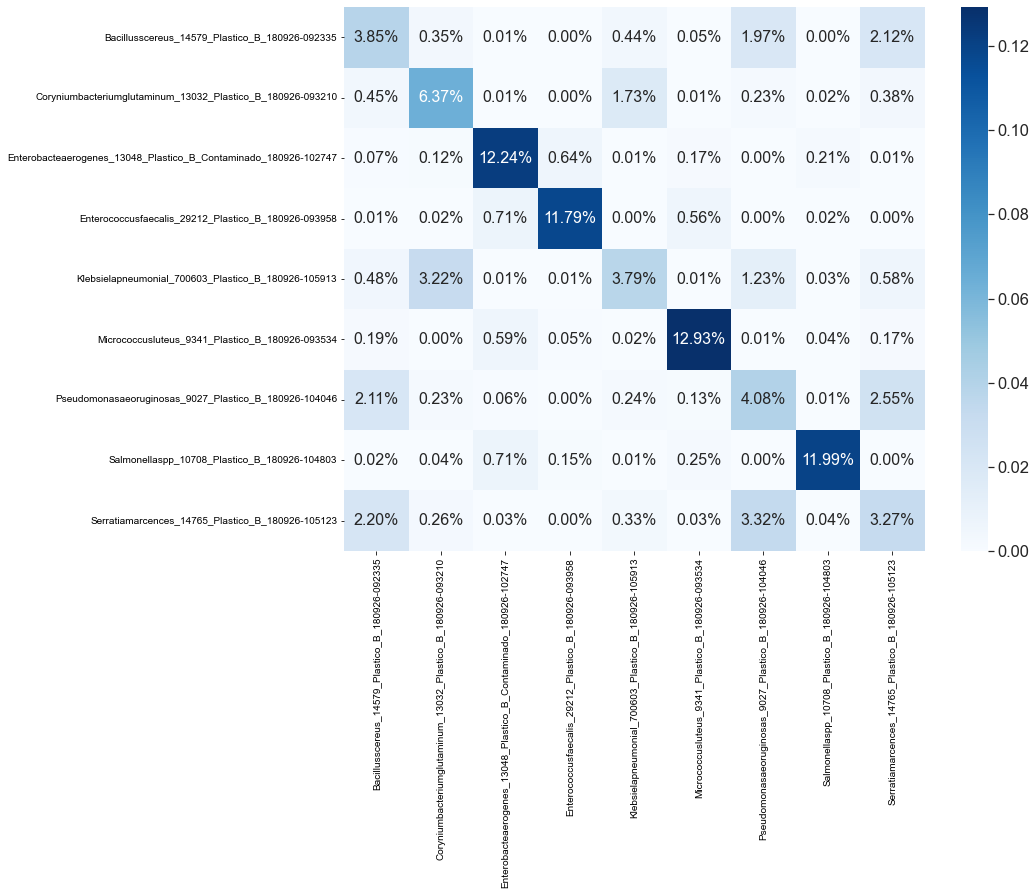

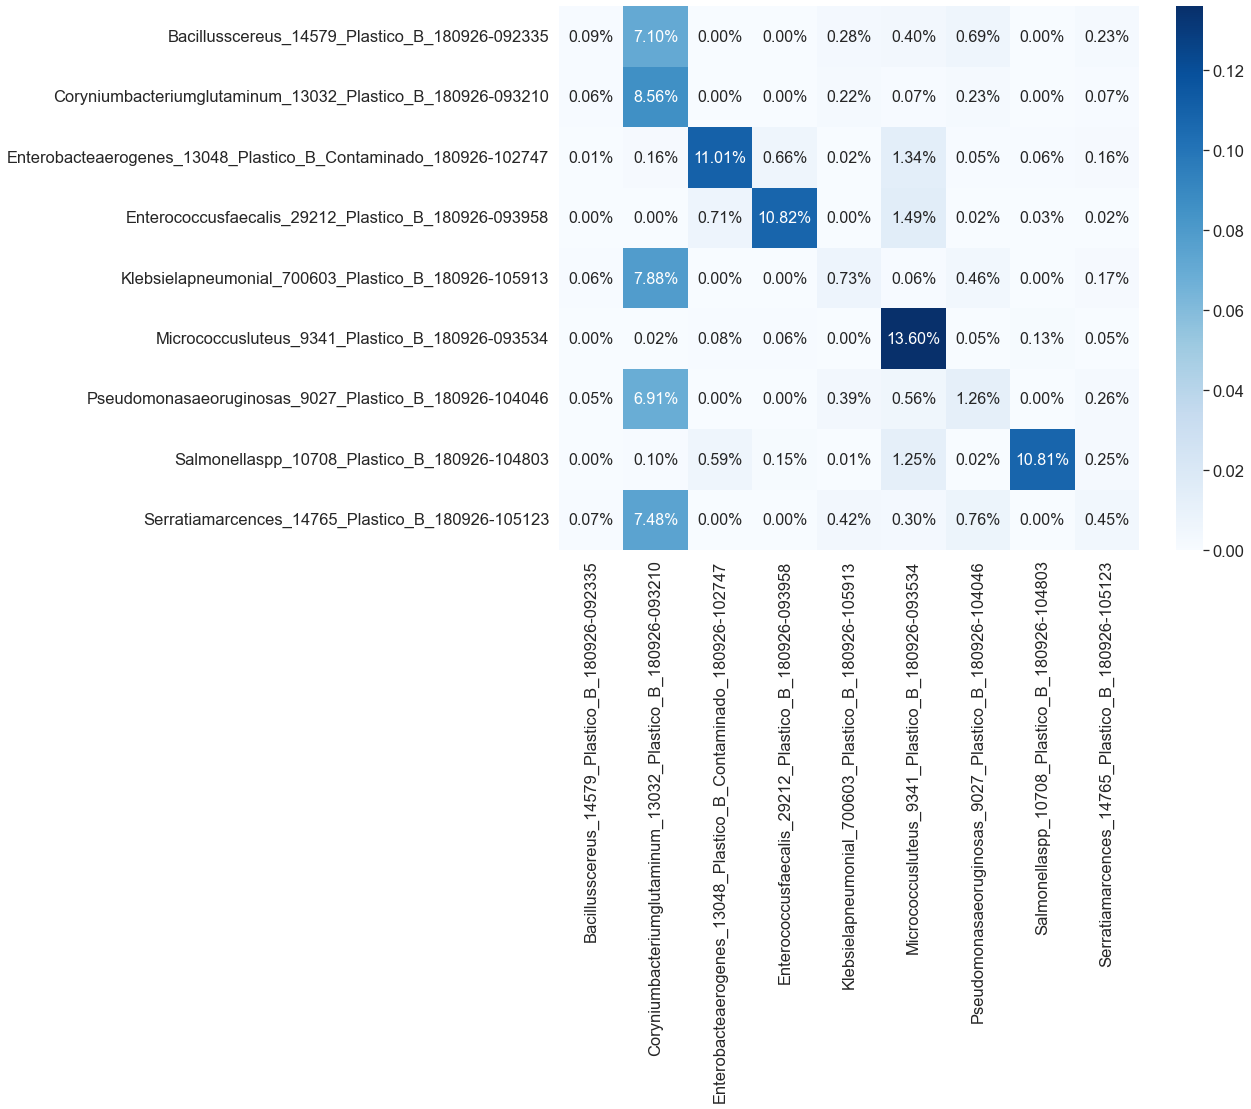

In [12]:
"""
    Everything will be saved in out_dir
"""

out_dir = 'outputs'
pipeline.train_models(x_train=X_train, 
                      x_test=X_test, 
                      y_train=y_train, 
                      y_test=y_test, 
                      models=models,
                      samples_dict=samples_dict,
                      target_names=target_names,
                      models_file=models_file,
                      work_dir=out_dir)